## Pipeline Quiz Generator (Separate Quiz and Distractor Approach)

Description: Quiz Generator with separate pipeline for quiz generation and then distractor generator

### Step 1 : SciQ Loading

Load dataset

In [1]:
from datasets import load_dataset

sciq_dataset = load_dataset("allenai/sciq")
sciq_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 11679
    })
    validation: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 1000
    })
})

In [2]:
filtered_sciq = sciq_dataset.filter(lambda example: example["support"] != '')
filtered_sciq

DatasetDict({
    train: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 10481
    })
    validation: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 887
    })
    test: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 884
    })
})

In [3]:
import pandas as pd
df_train = pd.DataFrame(filtered_sciq["train"].shuffle())
df_train.head()

,question,distractor3,distractor1,distractor2,correct_answer,support
0,What organs filter wastes from blood so they c...,liver,lungs,pancreas,kidneys,Vertebrates have an excretory system that incl...
1,"In a food chain, only about 10 percent of what...",hydrogen,mineral,vitamins,energy,"At each level of a food chain, a lot of energy..."
2,What is the term for the steep sloped side of ...,slide face,front face,break face,slip face,A sand dune has a gentle slope on the side the...
3,What type of waves are the slowest of all seis...,central waves,core waves,thick waves,surface waves,Surface waves travel along the ground outward ...
4,What lengths are positive for converging lens ...,differential lengths,light lengths,wavelengths,focal lengths,"- For lenses, the distance from the center of ..."


Check for support with longer than 512 tokens/words (Maximum token of T5).

In [4]:
print(df_train['support'].str.len().max())

3559


In [5]:
test = filtered_sciq.filter(lambda example: len(example["support"]) > 3000) 
test

DatasetDict({
    train: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 0
    })
    test: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 0
    })
})

In [6]:
test_data = test['train'][7]
test_data['support']

'membrane gradients was known, Mitchell proposed that energy captured through the absorption of light (by phototrophs) or the breakdown of molecules into more stable molecules (by various types of chemotrophs) relied on the same basic (homologous) mechanism, namely the generation of H+ gradients across membranes (the plasma membrane in prokaryotes or the internal membranes of mitochondria or chloroplasts (intracellular organelles, derived from bacteria – see below) in eukaryotes. What makes us think that these processes might have a similar evolutionary root, that they are homologous? Basically, it is the observation that in both light- and chemical-based processes captured energy is transferred through the movement of electrons through a membrane-embedded “electron transport chain”. An electron transport chain involves a series of membrane and associated proteins and a series of reduction-oxidation or redox reactions (see below) during which electrons move from a high energy donor to 

We can see above that support is long but only a few sentences is relevant, we cannot do raw summarization, we have to extract text based on keywords which are answers (distractors and keywords from questions too!). If we left this, support and answer will be truncated. If we summarize it raw, we lose important info of what is asked.

Extractive Summarization based on answer and questions

In [7]:
import yake

def extract_question(question):
    kw_extractor = yake.KeywordExtractor(top=10, stopwords=None)
    keywords = kw_extractor.extract_keywords(question)
    return [keyword for keyword, score in keywords]

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    lemmatizer = nlp.get_pipe("lemmatizer")
    doc = nlp(text)
    tokens = [tok for tok in doc]
    lemmas = [tok.lemma_ for tok in tokens]
    return ' '.join(lemmas)

In [9]:
def score_sentence(sentence, words):
    score = 0
    clean_sentences = clean_text(sentence.lower())
    for word in words:
        if clean_text(word.lower()) in clean_sentences:
            score += 1
    return score

In [10]:
def summarize_support(example, max_words=256):
    text = example["support"]
    words = extract_question(example["question"])
    words.extend([test_data["correct_answer"]])

    scored_sentences = (
        (i, sentence, score_sentence(sentence, words))
        for i, sentence in enumerate(text.split("."))
        if any(clean_text(w.lower()) in clean_text(sentence.lower()) for w in words)
    )
    ranked_sentences = sorted(scored_sentences, key=lambda x: x[2], reverse=True)

    sentence_in_summary = []
    sum_of_words = 0
    for order, sentence, _ in ranked_sentences:
        num_of_words = len(sentence.split())
        if sum_of_words + num_of_words < max_words:
            sentence_in_summary.append((order, sentence))
            sum_of_words += num_of_words 

    summary = sorted(sentence_in_summary, key=lambda x: x[1])
    return ".".join(sent for _, sent in summary)

summarize_support(test_data)

' ) The major pigment in this system, chlorophyll, is based on a complex molecule, a porphyrin (see above) and it is primarily these pigments that give plants their green color. At this point, we consider only one aspect of this photosynthetic system, known as the oxygenic or non-cyclic system (look to more advanced classes for more details. Chlorophyll is synthesized by a conserved biosynthetic pathway that is also used to synthesize heme, which is found in the hemoglobin of animals and in the cytochromes, within the electron transport chain present in both plants and animals (which. For simplicity’s sake we will describe the photosynthetic system of cyanobacterium; the system in eukaryotic algae and plants, while more complex, follows the same basic logic. In all of these organisms, their photosynthetic systems appear to be homologous, that is derived from a common ancestor, a topic we will return to later in this chapter. Oxygenic photosynthesis \u2028 Compared to the salt loving ar

In [11]:
def generate_context_with_question(example, max_token_size=512):
    answer_size = len(example['correct_answer'].split())
    question_size = len(example['question'].split())
    support_size = len(example['support'].split())

    # Add into account separator (<sep>) which are 2
    words_len = answer_size + support_size + question_size + 2
    context = example['support']

    if words_len > max_token_size:
        max_new_token_size = max_token_size - answer_size - question_size - 2
        context = summarize_support(example, max_words=max_new_token_size)
    
    return {
        "context": context
    }

# preprocessed_sciq = filtered_sciq.map(generate_context_with_question, num_proc=4)

In [12]:
# preprocessed_sciq.save_to_disk("preprocessed_sciq-dg-512-new")

Now preprocessed has shorter context for long ones, due to map process running slow, uncomment below after getting zip file from me

In [13]:
from datasets import load_from_disk
preprocessed_sciq = load_from_disk("preprocessed_sciq-dg-512-new")

### Step 2 Distractor Generation

#### Tokenize for Distractor Generation

Input : Context and Answer and Question
Output : 3 Distractors

In [38]:
import torch
import copy
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
tokenizer.add_special_tokens({"sep_token": "<sep>"})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [15]:
def preprocess_dataset(example):
    text = "{} <sep> {} <sep> {}".format(example['question'], example['correct_answer'], example['context'])
    distractor = "{} <sep> {} <sep> {}".format(example['distractor3'], example['distractor2'], example['distractor1'])

    max_length = 512
    max_length_target=16
    
    tokenized_inputs = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    tokenized_targets = tokenizer.encode_plus(distractor, max_length=max_length_target, padding='max_length', truncation=True, return_tensors="pt")
    
    input_ids = tokenized_inputs['input_ids'].squeeze()
    input_attention = tokenized_inputs['attention_mask'].squeeze()

    target_ids = tokenized_targets['input_ids'].squeeze()
    target_attention = tokenized_targets['attention_mask'].squeeze()

    labels = copy.deepcopy(target_ids)
    labels[labels == 0] = -100
    
    outputs = {
        'input_ids':input_ids, 
        'attention_mask': input_attention, 
        'labels': labels
    }

    return outputs
    
tokenized_dataset = preprocessed_sciq.map(preprocess_dataset, remove_columns= ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support', 'context'])
tokenized_dataset.set_format("torch")

In [16]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import T5ForConditionalGeneration

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(device)

train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=2)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=2)

optimizer = AdamW(model.parameters(), lr=3e-4)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [17]:
class EarlyStopping:
    def __init__(self, tolerance=3, min_delta=0.5):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [18]:
torch.cuda.empty_cache()

In [19]:
import evaluate
from tqdm.auto import tqdm

def validate(model, eval_dataloader):
    metric = evaluate.load("accuracy")
    model.eval()
    progress_bar_val = tqdm(range(len(eval_dataloader)), leave=False)
    
    total_loss = 0
    total_batches = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        total_batches += 1
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds_flatten = torch.flatten(predictions)
        refs_flatten = torch.flatten(batch["labels"])
        metric.add_batch(predictions=preds_flatten, references=refs_flatten)
        progress_bar_val.update(1)
    average_loss = total_loss/total_batches
    val_accuracy = metric.compute()
    progress_bar_val.close()
    return average_loss, val_accuracy['accuracy']

2024-03-27 22:47:46.039024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 22:47:46.039297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 22:47:46.287854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 22:47:46.779261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 22:47:53.264716: W tensorflow/compiler/tf2

In [21]:
def train(model, train_dataloader, eval_dataloader, num_training_steps, num_epochs):
    progress_bar = tqdm(range(num_training_steps), unit="batch")
    early_stopping = EarlyStopping()
    model.train()

    history = []
    
    for epoch in range(num_epochs):
        running_loss = 0
        total_batches = 0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            total_batches += 1
            progress_bar.set_description(f"Epoch {epoch + 1}")
            progress_bar.update(1)
        train_loss = running_loss/total_batches
        val_loss, val_acc = validate(model, eval_dataloader)
        
        torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'flan-T5-finetuned-dg-{}-run-2nd'.format(epoch + 1))
        
        print("Epoch {} : Training Loss {} Val Loss {} Val Acc {}%".format(epoch + 1, train_loss, val_loss, val_acc))

        history.append((train_loss, val_loss))
        
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
          print("We are at epoch:", epoch)
          break

    return model, history
model, history = train(model, train_dataloader, eval_dataloader, num_training_steps, num_epochs)

  0%|          | 0/13110 [00:00<?, ?batch/s]

  0%|          | 0/444 [00:00<?, ?it/s]

Epoch 1 : Training Loss 2.6819835144722397 Val Loss 2.457596265786403 Val Acc 0.3788049605411499%


  0%|          | 0/444 [00:00<?, ?it/s]

Epoch 2 : Training Loss 2.0912927049066528 Val Loss 2.352377404232283 Val Acc 0.3886696730552424%


  0%|          | 0/444 [00:00<?, ?it/s]

Epoch 3 : Training Loss 1.7828742909486015 Val Loss 2.3953487464973517 Val Acc 0.39085400225479144%


  0%|          | 0/444 [00:00<?, ?it/s]

Epoch 4 : Training Loss 1.4296765853938576 Val Loss 2.6094586690803907 Val Acc 0.38697857948139797%


  0%|          | 0/444 [00:00<?, ?it/s]

Epoch 5 : Training Loss 1.039513142940018 Val Loss 2.945134276473844 Val Acc 0.3822576099210823%
We are at epoch: 4


Early stopped manually at epoch 6, best model is at epoch 3 

In [22]:
history

[(2.6819835144722397, 2.457596265786403),
 (2.0912927049066528, 2.352377404232283),
 (1.7828742909486015, 2.3953487464973517),
 (1.4296765853938576, 2.6094586690803907),
 (1.039513142940018, 2.945134276473844)]

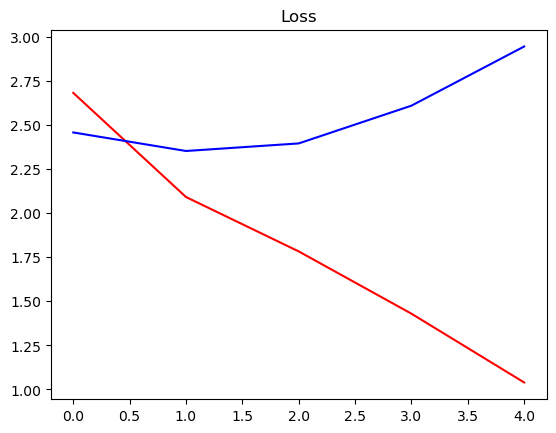

In [24]:
import matplotlib.pyplot as plt

train_loss, val_loss = zip(*history)

plt.plot(train_loss, color = 'r')
plt.plot(val_loss, color = 'b')

# Optionally, add labels and a title
plt.title('Loss')

# Display the plot
plt.show()

In [25]:
def evaluate_model(model, test_dataloader):
    metric_bleu = evaluate.load("bleu")
    model.eval()
    progress_bar_test = tqdm(range(len(test_dataloader)), leave=False)

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        preds_flatten = torch.flatten(predictions)
        refs_flatten = torch.flatten(batch["labels"])

        refs_flatten[refs_flatten == -100] = 0

        preds_questions = tokenizer.batch_decode(preds_flatten, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        refs_questions = tokenizer.batch_decode(refs_flatten, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        metric_bleu.add_batch(predictions=preds_questions, references=refs_questions)
        progress_bar_test.update(1)
    test_bleu = metric_bleu.compute()
    progress_bar_test.close()
    return test_bleu

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").to(device)
model.load_state_dict(torch.load('flan-T5-finetuned-dg-2-run-2nd')['model_state_dict'])

evaluate_model(model, test_dataloader)

  0%|          | 0/442 [00:00<?, ?it/s]

{'bleu': 0.36075958577107736,
 'precisions': [0.6291525423728813,
  0.7178679588128407,
  0.6904422253922967,
  0.5452212957023733],
 'brevity_penalty': 0.5618141971124424,
 'length_ratio': 0.6342826899540207,
 'translation_length': 19175,
 'reference_length': 30231}

In [35]:
def inference(model, question, answer, context):
    text = "{} <sep> {} <sep> {}".format(question, answer, context)
    max_length = 512
    tokenized_inputs = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt").to(device) 
    decoder_input_ids = tokenized_inputs['input_ids']

    output = model.generate(
        input_ids=tokenized_inputs['input_ids']
    )
    
    distractors = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return distractors

test = preprocessed_sciq['test'][880]
test

{'question': 'What do you call the ancient cores of continents, where the earliest continental crust is now found?',
 'distractor3': 'mantles',
 'distractor1': 'craters',
 'distractor2': 'escarpments',
 'correct_answer': 'cratons',
 'support': 'The earliest continental crust is now found in the ancient cores of continents, called the cratons . Geologists can learn many things about the Precambrian by studying the rocks of the cratons.',
 'context': 'The earliest continental crust is now found in the ancient cores of continents, called the cratons . Geologists can learn many things about the Precambrian by studying the rocks of the cratons.'}

In [36]:
inference(model, test['question'], test['correct_answer'], test['context'])

['craters craters craters']

In [143]:
from huggingface_hub import notebook_login

notebook_login()

In [144]:
model.push_to_hub("distractor-generation")

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rizkiduwinanto/distractor-generation/commit/ca9be0bd6cb9c1fe4420a17cd5e121ebd31c61ed', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='ca9be0bd6cb9c1fe4420a17cd5e121ebd31c61ed', pr_url=None, pr_revision=None, pr_num=None)